# 2. Normal (unknown mean and variance)

We will use priors:
$$
\sigma \sim \mathcal{U}(0, A) \quad \quad \mu \sim \mathcal{N}(\mu_0 \sigma_0^2)
$$

Then we have a collection of normal random variables $X_1,...,X_n$:
$$
(X_i | \mu, \sigma) \sim \mathcal{N}(\mu, \sigma^2)
$$


This means that our likelihood is:
$$
p(x | \mu, \sigma) = \prod_{i=1}^n \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{(x_i - \mu)^2}{2\sigma^2}\right)
$$



## Data generation

In [1]:
index_to_plot = 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

sigma0 = 1
mu0 = 0

A = 1
k = 1000 # number of datasets
n = 10 # samples per dataset

np.random.seed(0)

sigmas = np.random.uniform(0, A, size=k)
mus = np.random.normal(mu0, sigma0, size=k)

X = np.random.normal(mus[:, None], sigmas[:, None], size=(k, n))


# plot sigmas vs mus
plt.scatter(sigmas, mus, alpha=0.5)
plt.xlabel('sigma')
plt.ylabel('mu')
plt.scatter(sigmas[index_to_plot], mus[index_to_plot], color='red', label='True parameters')
plt.title('priors samples for mu and sigma')
plt.show()

# plot histogram of one dataset
plt.hist(X[index_to_plot], bins=20, density=False, alpha=0.5)
plt.xlabel('x')
plt.ylabel('count')
plt.axvline(mus[index_to_plot], color='red', label='True mu')
plt.axvline(mus[index_to_plot] - sigmas[index_to_plot], color='green', linestyle='--', label='True mu - sigma')
plt.axvline(mus[index_to_plot] + sigmas[index_to_plot], color='green', linestyle='--', label='True mu + sigma')
plt.legend()
plt.title(f'Dataset {index_to_plot}')

## Metropolis-Hastings (MH)

Our posterior by Bayes' theorem:
$$
\begin{aligned}
p(\mu, \sigma | x) &\propto p(x | \mu, \sigma) p(\mu) p(\sigma) \\
&\propto \left(\prod_{i=1}^n \frac{1}{\sqrt{2 \pi} \sigma} \exp\left(-\frac{(x_i - \mu)^2}{2\sigma^2}\right)\right) \left(\frac{1}{\sqrt{2 \pi} \sigma_0} \exp\left(-\frac{(\mu - \mu_0)^2}{2\sigma_0^2}\right)\right) \left(\frac{1}{A}\right) \\
&\propto \sigma^{-n} \exp\left(-\frac{1}{2\sigma^2}\sum_{i=1}^n (x_i - \mu)^2 -\frac{1}{2\sigma^2} \frac{(\mu - \mu_0)^2}{\sigma_0^2}\right)
\end{aligned}
$$

This gives us the log-posterior:
$$
\log p(\mu, \sigma | x) = -n \log \sigma - \frac{1}{2\sigma^2} \left(\sum_{i=1}^n (x_i - \mu)^2 + \frac{(\mu - \mu_0)^2}{\sigma_0^2}\right) + C 
$$
With the added condition that this will be $-\infty$ if $\sigma \notin (0, A)$.

In an attempt to employ summary statistics, we use the identity $\sum_{i=1}^n (x_i - \mu)^2 = \sum_{i=1}^n (x_i - \bar{x})^2 + n(\bar{x} - \mu)^2$, this gives:
$$
\log p(\mu, \sigma | x) = -n \log \sigma - \frac{1}{2\sigma^2} \left(S + n(\bar{x} - \mu)^2 + \frac{(\mu - \mu_0)^2}{\sigma_0^2}\right) + C
$$
Where we have introduced our summary statistics:
- $\bar{x} := \frac{1}{n} \sum_{i=1}^n x_i$ is the sample mean
- $S:= \sum_{i=1}^n (x_i - \bar{x})^2$ is n-1 times the sample variance


Acceptance rate: 0.72


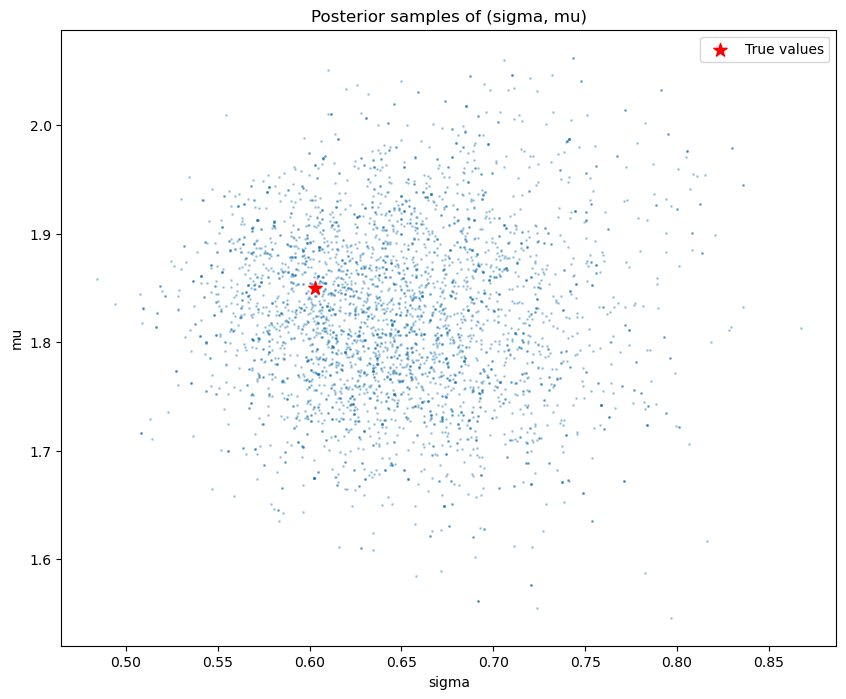

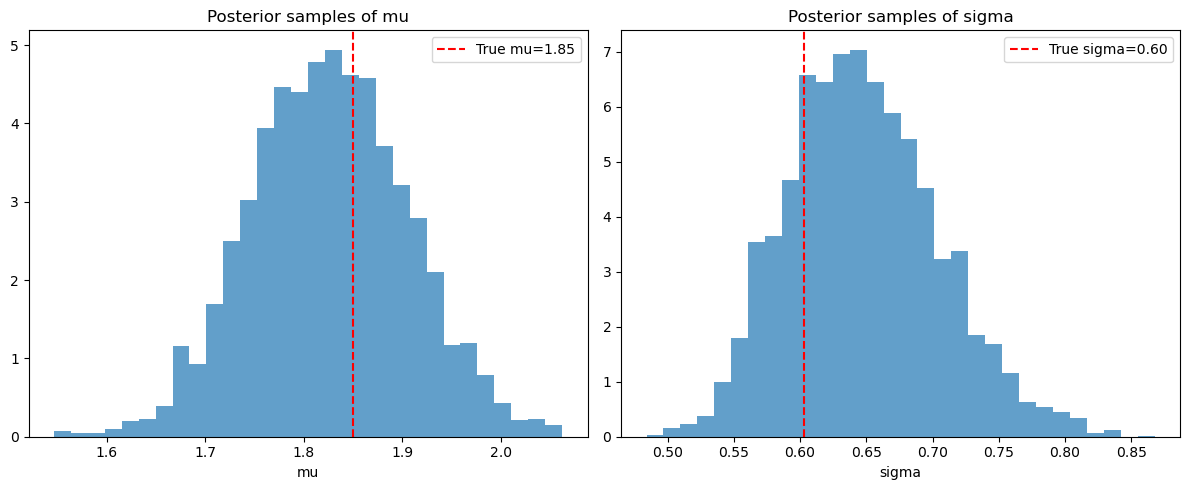

True mu: 1.8496, Posterior mean: 1.8257
True sigma: 0.6028, Posterior mean: 0.6479


In [ ]:
def log_posterior(mu, log_sigma, x_bar, S, n, mu0=mu0, sigma0=sigma0, A=A):
    sigma = np.exp(log_sigma)
    if sigma <= 0 or sigma >= A:
        return -np.inf

    sigma_sq = sigma**2
    exp_component = S + n * (x_bar - mu)**2 + ((mu - mu0)**2) / (sigma0**2)

    return -n * log_sigma - (1 / (2 * sigma_sq)) * exp_component

def metropolis_hastings(S, n, x_bar, n_samples=5000, tau_mu=0.1, tau_theta=0.1, burn_in=1000):
    samples = np.zeros((n_samples, 2))

    mu = np.random.normal(mu0, sigma0)
    log_sigma = np.log(np.random.uniform(0.1, A))

    samples[0, 0] = mu
    samples[0, 1] = np.exp(log_sigma)

    accepted = 0

    for i in range(1, n_samples):
        mu_proposal = mu + np.random.normal(0, tau_mu)
        log_sigma_proposal = log_sigma + np.random.normal(0, tau_theta)

        log_post_current = log_posterior(mu, log_sigma, x_bar, S, n)
        log_post_proposal = log_posterior(mu_proposal, log_sigma_proposal, x_bar, S, n)

        log_acceptance_ratio = log_post_proposal - log_post_current

        if np.log(np.random.rand()) < log_acceptance_ratio:
            mu = mu_proposal
            log_sigma = log_sigma_proposal
            accepted += 1

        samples[i, 0] = mu
        samples[i, 1] = np.exp(log_sigma)
     
    print(f'Acceptance rate: {accepted / n_samples:.2f}')
    return samples[burn_in:]


xs = X[index_to_plot]
x_bar = np.mean(xs)
S = np.sum((xs - x_bar)**2)

samples_mh = metropolis_hastings(S, n, x_bar, n_samples=5000, tau_mu=0.05, tau_theta=0.05, burn_in=1000)

plt.figure(figsize=(10, 8))
plt.scatter(samples_mh[:, 1], samples_mh[:, 0], alpha=0.3, s=1)
plt.scatter(sigmas[index_to_plot], mus[index_to_plot], color='r', s=100, marker='*', label='True values')
plt.xlabel('sigma')
plt.ylabel('mu')
plt.title('Posterior samples of (sigma, mu)')
plt.legend()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(samples_mh[:, 0], bins=30, density=True, alpha=0.7)
axes[0].axvline(mus[index_to_plot], color='r', linestyle='--', label=f'True mu={mus[index_to_plot]:.2f}')
axes[0].set_xlabel('mu')
axes[0].set_title('Posterior samples of mu')
axes[0].legend()

axes[1].hist(samples_mh[:, 1], bins=30, density=True, alpha=0.7)
axes[1].axvline(sigmas[index_to_plot], color='r', linestyle='--', label=f'True sigma={sigmas[index_to_plot]:.2f}')
axes[1].set_xlabel('sigma')
axes[1].set_title('Posterior samples of sigma')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"True mu: {mus[index_to_plot]:.4f}, Posterior mean: {np.mean(samples_mh[:, 0]):.4f}")
print(f"True sigma: {sigmas[index_to_plot]:.4f}, Posterior mean: {np.mean(samples_mh[:, 1]):.4f}")

Questions
- do we have any way of representing the count $n$ in nn appraoch?

## Neural Network Inference (posterior mean)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as nnf

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_layers=2):
        super(MLP, self).__init__()
        
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.nn = nn.Sequential(*layers)

    def forward(self, x):
        return self.nn(x)

class JointPosteriorEstimator(nn.Module):
    def __init__(self,
        summary_stats=32,
        summary_width=32,
        estimator_width=32):
        
        super().__init__()

        self.mlp_point = MLP(
            input_dim=1, 
            output_dim=summary_stats, 
            hidden_dim=summary_width,
            n_layers=2)

        self.mlp_aggregate = MLP(
            input_dim=summary_stats, 
            output_dim=2,
            hidden_dim=estimator_width,
            n_layers=2)

    def forward(self, x):
        x = x.unsqueeze(-1).float()  # (batch_size, n, 1)
        summaries = self.mlp_point(x)  # (batch_size, n, summary_stats)
        H = summaries.sum(dim=1)  # (batch_size, summary_stats)
        out = self.mlp_aggregate(H)  # (batch_size, 2)

        # assume output of form (mu, sigma)
        mu_hat = out[:, 0]
        sigma_hat = nnf.softplus(out[:, 1])

        return torch.stack([mu_hat, sigma_hat], dim=1)

# Test untrained network
input_obs = torch.tensor(X[index_to_plot], dtype=torch.float32).unsqueeze(0)
neural_estimator = JointPosteriorEstimator()
theta_hat = neural_estimator(input_obs)

print(f"True mu: {mus[index_to_plot]:.2f}, sigma: {sigmas[index_to_plot]:.2f}")
print(f"Initial mu_hat: {theta_hat[0, 0].item():.2f}, sigma_hat: {theta_hat[0, 1].item():.2f}")

True mu: 1.85, sigma: 0.60
Initial mu_hat: 1.46, sigma_hat: 2.03


### Training

In [ ]:
def sample_batch(batch_size, mu0, sigma0, A, n):
    mu_batch = torch.from_numpy(np.random.normal(mu0, sigma0, size=batch_size)).float()
    sigma_batch = torch.from_numpy(np.random.uniform(0, A, size=batch_size)).float()
    
    x_batch = torch.zeros(batch_size, n)
    for i in range(batch_size):
        x_batch[i] = torch.from_numpy(
            np.random.normal(mu_batch[i].item(), sigma_batch[i].item(), size=n)
        ).float()
    
    theta_batch = torch.stack([mu_batch, sigma_batch], dim=1)
    return theta_batch, x_batch

# Generate test set
theta_test, x_test = sample_batch(1024, mu0, sigma0, A, n)

loss_fn = torch.nn.MSELoss()
test_output = neural_estimator(x_test)
test_loss = loss_fn(test_output, theta_test)
print(f"Initial test loss: {test_loss:.4f}")

Initial test loss: 1.2787


Epoch 8/64, Train Loss: 0.0210, Test Loss: 0.0193
Epoch 16/64, Train Loss: 0.0128, Test Loss: 0.0122
Epoch 24/64, Train Loss: 0.0087, Test Loss: 0.0084
Epoch 32/64, Train Loss: 0.0072, Test Loss: 0.0069
Epoch 40/64, Train Loss: 0.0066, Test Loss: 0.0066
Epoch 48/64, Train Loss: 0.0063, Test Loss: 0.0060
Epoch 56/64, Train Loss: 0.0059, Test Loss: 0.0056
Epoch 64/64, Train Loss: 0.0056, Test Loss: 0.0055


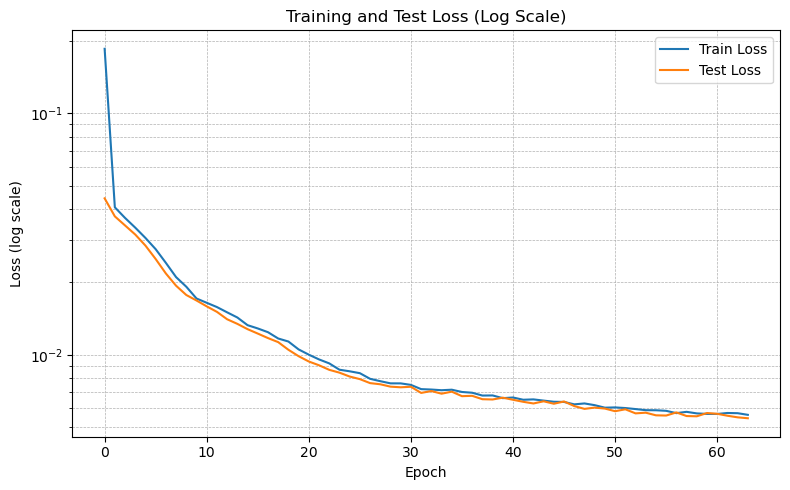

In [ ]:
n_epochs = 64
n_batches_per_epoch = 128
training_batch_size = 128

optimizer = torch.optim.Adam(neural_estimator.parameters(), lr=0.0001)

train_losses = []
test_losses = []

for epoch in range(n_epochs):
    epoch_loss = 0.0
    
    for batch_idx in range(n_batches_per_epoch):
        theta_batch, x_batch = sample_batch(training_batch_size, mu0, sigma0, A, n)
        
        optimizer.zero_grad()
        theta_pred = neural_estimator(x_batch)
        loss = loss_fn(theta_pred, theta_batch)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_epoch_loss = epoch_loss / n_batches_per_epoch
    train_losses.append(avg_epoch_loss)
    
    with torch.no_grad():
        theta_pred_test = neural_estimator(x_test)
        test_loss = loss_fn(theta_pred_test, theta_test).item()
        test_losses.append(test_loss)
    
    if (epoch + 1) % 8 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_epoch_loss:.4f}, Test Loss: {test_loss:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.yscale('log')  # Set y-axis to log scale
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.title('Training and Test Loss (Log Scale)')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

## Comparison: Neural Network vs MCMC

In [ ]:
# Generate new test data
theta_compare, x_compare = sample_batch(256, mu0, sigma0, A, n)

# Neural network predictions
with torch.no_grad():
    theta_nn = neural_estimator(x_compare).numpy()

# MCMC estimates
theta_mcmc = np.zeros((x_compare.shape[0], 2))
for i in range(x_compare.shape[0]):
    xs = x_compare[i].numpy()
    x_bar_i = np.mean(xs)
    S_i = np.sum((xs - x_bar_i)**2)
    samples = metropolis_hastings(S_i, n, x_bar_i, n_samples=2000, tau_mu=0.05, tau_theta=0.05, burn_in=500)
    theta_mcmc[i, 0] = np.mean(samples[:, 0])  # mu
    theta_mcmc[i, 1] = np.mean(samples[:, 1])  # sigma

theta_true = theta_compare.numpy()

Acceptance rate: 0.72
Acceptance rate: 0.36
Acceptance rate: 0.71
Acceptance rate: 0.40
Acceptance rate: 0.46
Acceptance rate: 0.73
Acceptance rate: 0.67
Acceptance rate: 0.73
Acceptance rate: 0.43
Acceptance rate: 0.54
Acceptance rate: 0.65
Acceptance rate: 0.49
Acceptance rate: 0.38
Acceptance rate: 0.62
Acceptance rate: 0.58
Acceptance rate: 0.71
Acceptance rate: 0.71
Acceptance rate: 0.63
Acceptance rate: 0.73
Acceptance rate: 0.68
Acceptance rate: 0.48
Acceptance rate: 0.50
Acceptance rate: 0.69
Acceptance rate: 0.54
Acceptance rate: 0.69
Acceptance rate: 0.56
Acceptance rate: 0.38
Acceptance rate: 0.65
Acceptance rate: 0.73
Acceptance rate: 0.66
Acceptance rate: 0.66
Acceptance rate: 0.67
Acceptance rate: 0.58
Acceptance rate: 0.67
Acceptance rate: 0.72
Acceptance rate: 0.73
Acceptance rate: 0.71
Acceptance rate: 0.69
Acceptance rate: 0.57
Acceptance rate: 0.66
Acceptance rate: 0.68
Acceptance rate: 0.63
Acceptance rate: 0.52
Acceptance rate: 0.72
Acceptance rate: 0.39
Acceptance

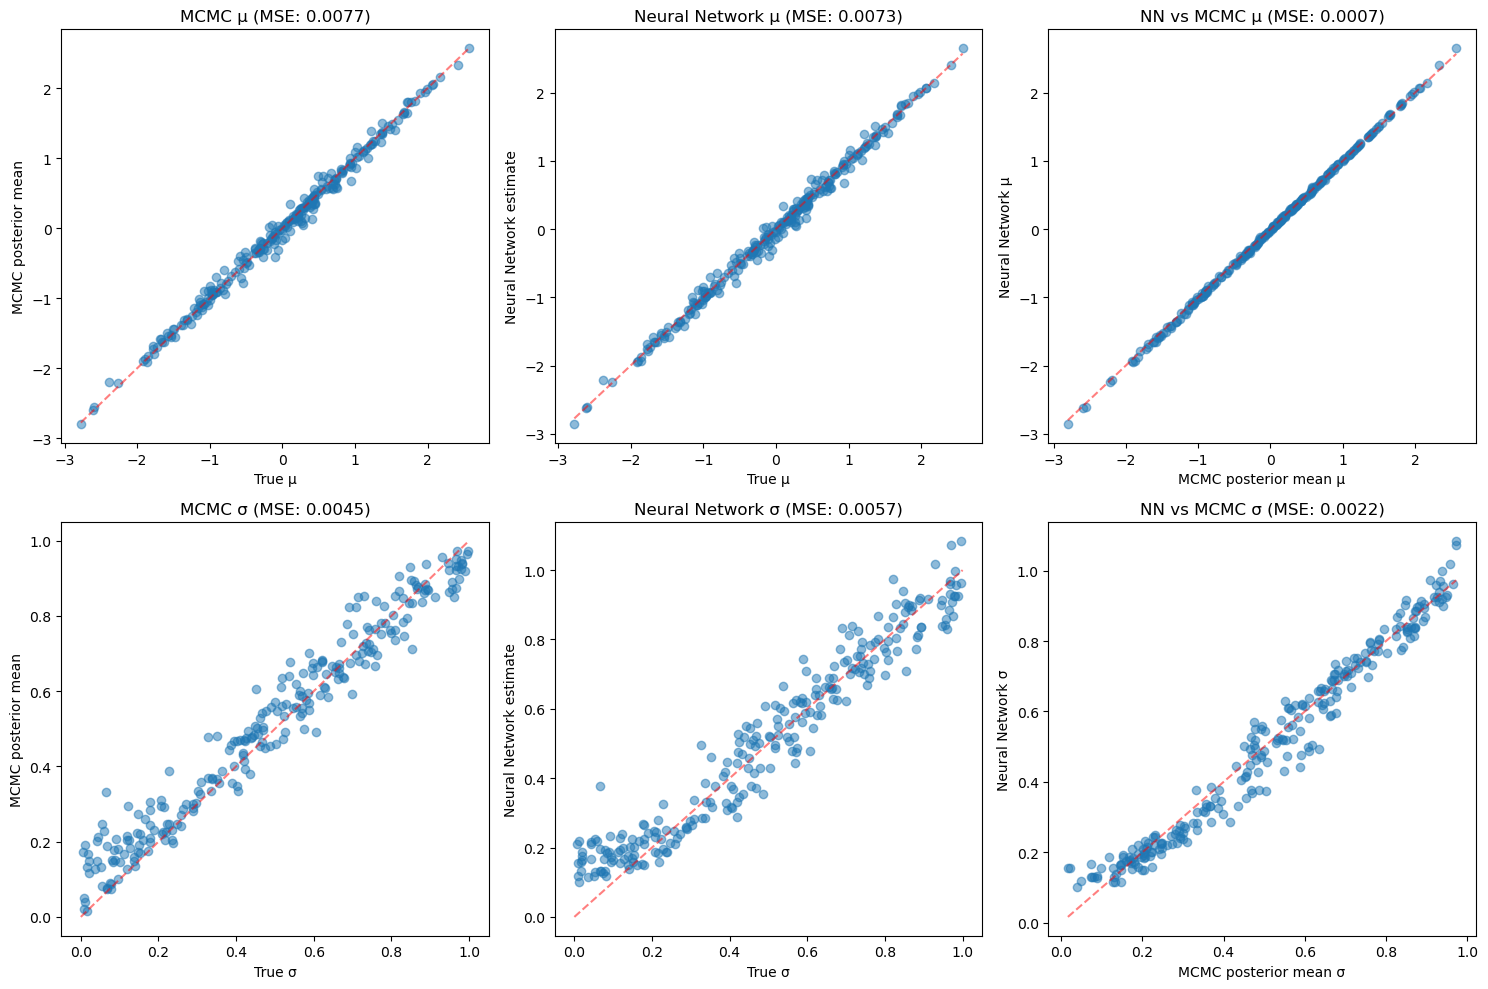

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Mu comparisons
axes[0, 0].scatter(theta_true[:, 0], theta_mcmc[:, 0], alpha=0.5)
axes[0, 0].plot([theta_true[:, 0].min(), theta_true[:, 0].max()], 
                [theta_true[:, 0].min(), theta_true[:, 0].max()], 'r--', alpha=0.5)
axes[0, 0].set_xlabel("True μ")
axes[0, 0].set_ylabel("MCMC posterior mean")
axes[0, 0].set_title(f"MCMC μ (MSE: {np.mean((theta_true[:, 0] - theta_mcmc[:, 0])**2):.4f})")

axes[0, 1].scatter(theta_true[:, 0], theta_nn[:, 0], alpha=0.5)
axes[0, 1].plot([theta_true[:, 0].min(), theta_true[:, 0].max()], 
                [theta_true[:, 0].min(), theta_true[:, 0].max()], 'r--', alpha=0.5)
axes[0, 1].set_xlabel("True μ")
axes[0, 1].set_ylabel("Neural Network estimate")
axes[0, 1].set_title(f"Neural Network μ (MSE: {np.mean((theta_true[:, 0] - theta_nn[:, 0])**2):.4f})")

axes[0, 2].scatter(theta_mcmc[:, 0], theta_nn[:, 0], alpha=0.5)
axes[0, 2].plot([theta_mcmc[:, 0].min(), theta_mcmc[:, 0].max()], 
                [theta_mcmc[:, 0].min(), theta_mcmc[:, 0].max()], 'r--', alpha=0.5)
axes[0, 2].set_xlabel("MCMC posterior mean μ")
axes[0, 2].set_ylabel("Neural Network μ")
axes[0, 2].set_title(f"NN vs MCMC μ (MSE: {np.mean((theta_mcmc[:, 0] - theta_nn[:, 0])**2):.4f})")

# Sigma comparisons
axes[1, 0].scatter(theta_true[:, 1], theta_mcmc[:, 1], alpha=0.5)
axes[1, 0].plot([0, A], [0, A], 'r--', alpha=0.5)
axes[1, 0].set_xlabel("True σ")
axes[1, 0].set_ylabel("MCMC posterior mean")
axes[1, 0].set_title(f"MCMC σ (MSE: {np.mean((theta_true[:, 1] - theta_mcmc[:, 1])**2):.4f})")

axes[1, 1].scatter(theta_true[:, 1], theta_nn[:, 1], alpha=0.5)
axes[1, 1].plot([0, A], [0, A], 'r--', alpha=0.5)
axes[1, 1].set_xlabel("True σ")
axes[1, 1].set_ylabel("Neural Network estimate")
axes[1, 1].set_title(f"Neural Network σ (MSE: {np.mean((theta_true[:, 1] - theta_nn[:, 1])**2):.4f})")

axes[1, 2].scatter(theta_mcmc[:, 1], theta_nn[:, 1], alpha=0.5)
axes[1, 2].plot([theta_mcmc[:, 1].min(), theta_mcmc[:, 1].max()], 
                [theta_mcmc[:, 1].min(), theta_mcmc[:, 1].max()], 'r--', alpha=0.5)
axes[1, 2].set_xlabel("MCMC posterior mean σ")
axes[1, 2].set_ylabel("Neural Network σ")
axes[1, 2].set_title(f"NN vs MCMC σ (MSE: {np.mean((theta_mcmc[:, 1] - theta_nn[:, 1])**2):.4f})")

plt.tight_layout()
plt.show()